In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

from model import RepVGGRegressor

In [12]:
def extractAreaOfInterest(image, bbox_path):
    with open(bbox_path, 'r') as f:
        bbox = f.readline()
    xmin, ymin, xmax, ymax = list(map(lambda x: int(x), bbox.split(";")))

    return image[ymin:ymax, xmin:xmax]

def resizeImage(image, im_shape):
    height, width = im_shape
    h, w = image.shape[:2]
    pad_bottom, pad_right = 0, 0
    ratio = w / h

    if h > height or w > width:
        # shrinking image algorithm
        interp = cv2.INTER_AREA
    else:
        # stretching image algorithm
        interp = cv2.INTER_CUBIC

    w = width
    h = round(w / ratio)
    if h > height:
        h = height
        w = round(h * ratio)
    pad_bottom = abs(height - h)
    pad_right = abs(width - w)

    scaled_image = cv2.resize(image, (w, h), interpolation=interp)
    padded_image = cv2.copyMakeBorder(
        scaled_image,0,pad_bottom,0,pad_right,borderType=cv2.BORDER_CONSTANT,value=[0,0,0])
    return padded_image

def createDepthMap(image, model_type="DPT_Hybrid"):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()
    
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    
    input_batch = transform(image).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    return output

def estimateContianerLevel(image, depthmap, model_state_path):
    model = RepVGGRegressor(channels=[4, 16, 32, 64, 128])
    # model.load_state_dict(torch.load(model_state_path))
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()
    
    convert_tensor = transforms.ToTensor()

    input_rgb = convert_tensor(image)
    input_depth = convert_tensor(depthmap)
    
    input_batch = torch.cat((input_depth, input_rgb), 0)
    
    with torch.no_grad():
        prediction = model(input_batch.unsqueeze(0).to(device))
    output = prediction.cpu().numpy()[0]
    return output

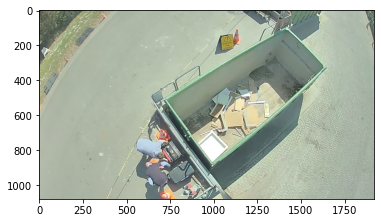

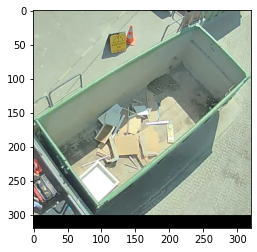

Using cache found in C:\Users\Jeanp/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Jeanp/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\Jeanp\anaconda3\envs\TFE\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


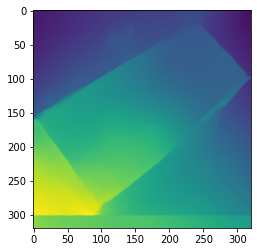

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  None
[0.31047028]


In [13]:
path_bbox = "bbox.txt"
path_image = ".jpg"
path_model = "container_level_regressor.pt"

image = cv2.imread(path_image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

image = extractAreaOfInterest(image, path_bbox)

image = resizeImage(image, (320,320))

plt.imshow(image)
plt.show()

depthmap = createDepthMap(image, "DPT_Hybrid")

plt.imshow(depthmap)
plt.show()

output = estimateContianerLevel(image, depthmap, path_model)

print(output)